In [132]:
import geopandas as gpd
import rasterio
import rasterio.features
from rasterio import features
from rasterio.plot import show
from rasterio.merge import merge    
import pyproj
import pathlib
import pandas
import zipfile
from shutil import copyfile
from pathlib import Path
from shapely.geometry import Polygon, box
from shapely import geometry, wkt
import geojson
import zipfile

import os
import glob

import json
from pprint import pprint, pformat
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
from terracatalogueclient import Catalogue 
from creodias_finder import query, download

**Input parameter**

In [115]:

# Insert the AOI polygons into the AOI folder

name = "uk"

#scenes
date_start, date_end= "20210101","20210201"

#AOI formatL: shp & geojson
format_aoi = "shp"

#WorldCover password & name
name_wc, password_wc = "sulova","Sulova327"

# Sentinel for creating the S2 scenes data"https://apihub.copernicus.eu/apihub"
sentinel_user, sentinel_pw = "sulova327", "sulova327"

# Creodias for downloading Copernicus DEM(30m)
creodias_user, creodias_pw = "ansu@dhigroup.com", "Sulova327"

# Default
dir_AOI =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}/AOI")
dir_work =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}")
S2_Grid =  gpd.read_file('/ncr2420/ANSU/3_Data/S2-Tiles/sentinel2_tiles_world.shp')


In [116]:
# create folder with the AOI name
#aoidir = os.path.join(dir_AOI,"superseded")

#if not os.path.exists(aoidir):
#       os.makedirs(aoidir)    

# 1. Merge all the AOI files

CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING


Number of files: 8


CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


[]

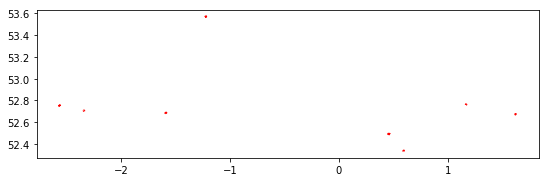

In [117]:
# delete previous files in the aoi folder
    
if os.path.isfile(os.path.join(dir_AOI, f'merge.geojson')):
    os.remove(os.path.join(dir_AOI, f'merge.geojson'))
if os.path.isfile(os.path.join(dir_AOI, f'merge.shp')):
    os.remove(os.path.join(dir_AOI, f'merge.shp'))    
   

files = glob.glob(f'{dir_AOI}/*.{format_aoi}')
print('Number of files:',len(files))
    
# merge AOI files together for finding S2 tiles
gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"
merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.geojson'), driver='GeoJSON')
merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.shp'))

ax_AOI = gdf_merge.plot(figsize = (9,13),facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

# 1.1 Find the matching S2 tiles

['30UWD', '30UXE', '30UYD', '31UCU', '31UDU']


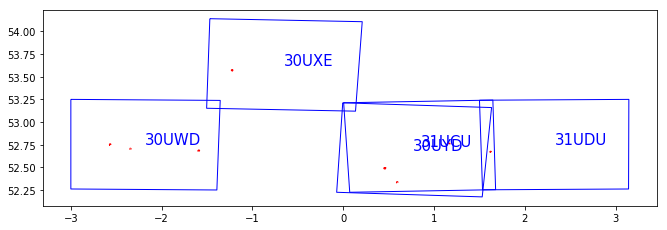

In [119]:
# intersection of S2 with AOI
intersection = gpd.overlay(S2_Grid, gdf_merge, how='intersection')
tiles_name = intersection['Name'].unique().tolist()
print(tiles_name)

# Plot of the S2 tiles and AOI
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})

ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})

for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)

# 1.2 Select the tiles to be export to geojson file

In [ ]:
#tiles_name = ['31UDU',"30UXE"]
tiles_name = ['31UDU',"30UXE","30UWD","30UYD"]

In [ ]:
# delete previsou files in the folder
file_json = glob.glob(f'{dir_work}/*.geojson')
for f in file_json:
    if os.path.isfile(f):
        os.remove(f)

# selec S2 tiles within the AOI        
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]

# Plot of the S2 tiles and AOI
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})
ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})
for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)
    
# Save S2 tile as a geojson file
for index, row in S2_Tile_Selection.iterrows():
    name_s2 = row["Name"]
    polygon = S2_Tile_Selection.loc[S2_Tile_Selection['Name'] == name_s2]
    out_name = os.path.join(dir_work, "{0}.geojson".format(name_s2))
    print("Saving the {0} tile:{1}  ".format(name,out_name))
    polygon.to_file(out_name, driver='GeoJSON')
        
        
# find the all AOI to one shp
files = glob.glob(f'{dir_work}/*.geojson')
print('Number of files:',len(files))
out_merge = os.path.join(dir_work, f"{name}.geojson")
gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"
merge_file = gdf_merge.to_file(out_merge, driver='GeoJSON')



# 1.3 Create scenes


In [121]:

#api_url='https://apihub.copernicus.eu/dhus'
api_url='https://scihub.copernicus.eu/dhus'

area = geojson_to_wkt(read_geojson(out_merge))

print(area)
output_file = os.path.join(dir_work, f"{name}_scenes.txt")

query_kwargs = {
    "platformname": "Sentinel-2",
    "producttype": "S2MSI1C",
    "cloudcoverpercentage": (0, 90),
    "date": (date_start, date_end),
    "tileid": area}

product = dict()
scenes = []

for tile in tiles_name:
    kw = query_kwargs.copy()
    kw["tileid"] = tile
    api = SentinelAPI(sentinel_user, sentinel_pw,api_url)
    api_product = api.query(**kw)
    dates = []
   
    for key, value in api_product.items():
        dates.append(value['datatakesensingstart'])
    dates = sorted(dates)[::-1]
    
    for d in dates:
        scenes.append({"date":f'{d:%Y-%m-%d}', 'tile':f'T{tile}'})

print(json.dumps(scenes))
with open(output_file, "w") as fp:
    fp.write(json.dumps(scenes, indent=1))

POLYGON((-3.0003 53.2496,-1.3551 53.2383,-1.3918 52.2516,-3.0003 52.2625,-3.0003 53.2496))
[{"date": "2021-01-25", "tile": "T31UDU"}, {"date": "2021-01-23", "tile": "T31UDU"}, {"date": "2021-01-21", "tile": "T31UDU"}, {"date": "2021-01-18", "tile": "T31UDU"}, {"date": "2021-01-13", "tile": "T31UDU"}, {"date": "2021-01-10", "tile": "T31UDU"}, {"date": "2021-01-08", "tile": "T31UDU"}, {"date": "2021-01-06", "tile": "T31UDU"}, {"date": "2021-01-06", "tile": "T31UDU"}, {"date": "2021-01-05", "tile": "T31UDU"}, {"date": "2021-01-03", "tile": "T31UDU"}, {"date": "2021-01-01", "tile": "T31UDU"}, {"date": "2021-01-29", "tile": "T30UXE"}, {"date": "2021-01-24", "tile": "T30UXE"}, {"date": "2021-01-21", "tile": "T30UXE"}, {"date": "2021-01-16", "tile": "T30UXE"}, {"date": "2021-01-09", "tile": "T30UXE"}, {"date": "2021-01-06", "tile": "T30UXE"}, {"date": "2021-01-04", "tile": "T30UXE"}, {"date": "2021-01-01", "tile": "T30UXE"}, {"date": "2021-01-29", "tile": "T30UWD"}, {"date": "2021-01-22", "ti

# 2. Copernicus DEM

In [134]:
dem_dir = f"{dir_work}/DEM/"
dem_aoi = f"{dir_work}/{name}.geojson"

merge_gpd = gpd.read_file(dem_aoi)
bounds_AOI = merge_gpd.total_bounds
geometry = box(*bounds_AOI) 

results_update = []

results = query.query('CopDem', geometry =geometry)
for result in results.values():
    productType = result["properties"]["productType"]
    if productType == "SAR_DGE_30_PUBLIC":
        title = result["properties"]["title"]
        ids = result["id"]
        download_title= os.path.join(dem_dir,title)
        download_id = os.path.join(dem_dir,f"{ids}.zip")
        if not os.path.exists(download_id):
            results_update.append(ids)  

print("Number of files:", len(results_update))

paths = download.download_list(list(results_update), creodias_user, creodias_pw, dem_dir,threads=10, show_progress=False)

for path in paths.values():
    with zipfile.ZipFile(path, "r") as z:
        z.extractall(dem_dir)
    os.remove(path)
    
DEM_tif = glob.glob(os.path.join(f"{dem_dir}DEM1*/Copernicus*/DEM/","*.tif"))

src_files_to_mosaic = []

# merge fils
for fp in DEM_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)    

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],"width": mosaic.shape[2],"transform": out_trans} )
with rasterio.open(f"{dir_work}/DEM.tif", "w", **out_meta) as dest:
    dest.write(mosaic)



Number of files: 16


# 3. Land Cover - World Cover

In [ ]:
# for tiles 

tileList = []

for tile in tiles_name:
    merge_gpd = gpd.read_file(f"{dir_work}/{tile}.geojson")
    bounds_AOI = merge_gpd.total_bounds
    geometry = box(*bounds_AOI)      
    # create catalogue object and authenticate 
    catalogue = Catalogue().authenticate() 
    catalogue = catalogue.authenticate_non_interactive(name_wc, password_WC) 
    # search for products in the WorldCover collection 
    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 
    for c in products:        
        title = c.properties['title']
        file_dir = f"{dir_work}/wordCover/{title}"
        if not os.path.isdir(file_dir):
            print(f"{tile} - {title} file NOT exists")
            products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry)
            catalogue.download_products(products, os.path.join(dir_work, f"wordCover"), force=True)
        else:
            print(f"{tile} - {title} exists")
            
            
LC_tif = glob.glob(os.path.join(f"{dir_work}/wordCover/*/","*Map.tif"))
src_files_to_mosaic = []

for fp in LC_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)   

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans} )

with rasterio.open(f"{dir_work}/WorldCover.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
         

# 4. Reclassify Land Cover - World Cover

In [ ]:
def rasterize_vector(gdf, profile, **kwargs):
    """Rasterize vector to geometry from rasterio
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        vector feature(s)
    profile : dict
        file profile like
        rasterio.open(...).profile
    Returns
    -------
    ndarray : binary mask where features are False
    """
    gdf = gdf.to_crs(profile['crs'])
    geoms = [g.__geo_interface__ for g in gdf.geometry.values]
    mask = rasterio.features.geometry_mask(
            geoms,
            out_shape=(profile['width'],profile['height']),
            transform=profile['transform'],
            **kwargs)
    return mask


def mask_raster_with_vector(rasterfile, vectorfile):
    """Rasterize vectorfile to geometry of rasterfile
    Parameters
    ----------
    rasterfile : str
        path to raster file
    vectorfile : str
        path to vector file (.vector, .geojson, ...)
        any format known to fiona
    Returns
    -------
    ndarray : binary mask where features are False
    """
    with rasterio.open(rasterfile) as src:
        profile = src.profile.copy()
        
        print(profile)
    gdf = gpd.read_file(vectorfile)
    return rasterize_vector(gdf, profile)



In [ ]:
shp_fn = '/ncr2420/ANSU/6_Tasks/2110_ET/test/belgium_west_polygon.shp' 
rst_fn = '/ncr2420/ANSU/6_Tasks/2110_ET/test/S2GLC_belgium_west_2017_old.tif' 
out_fn = '/ncr2420/ANSU/6_Tasks/2110_ET/test/'

In [ ]:
rasteer = mask_raster_with_vector(rst_fn,shp_fn)


In [ ]:
show(rasteer)


In [ ]:
def raster_file_singleband(path, rasterfile,data):
    with rasterio.open(rasterfile) as src:
        profile = src.profile.copy()
        print(profile)
    profile.update(driver="GTiff")
    with rasterio.open(str(path+"test_10.tif"), "w", **profile) as dst:
        dst.write(data.astype(rasterio.uint8), 1)
    return str(path+"test_10.tif")

In [ ]:
raster_file_singleband(out_fn,rst_fn,rasteer)

In [ ]:
raster_new= rasterio.open(out_fn+"test_10.tif")
show(raster_new)
raster_new.profile

In [ ]:
# open and update the metadata from the input raster for the output
rst = rasterio.open(rst_fn)
meta = rst.meta.copy()
meta.update(compress='lzw')

rst.read().shape



In [ ]:
# Open the file with GeoPANDAS read_file

polygons = gpd.read_file(shp_fn)
polygons.plot()
polygons.crs


In [ ]:
polygons_rasCRS = polygons.to_crs({'init': 'epsg:32631'})
polygons_rasCRS.crs
polygons_rasCRS.plot()

In [ ]:
#counties_pro= counties.set_crs(epsg=3857)
#counties_ proj = counties.to_crs('epsg:32631'

In [ ]:
polygons_rasCRS

In [ ]:
polygons_rasCRS["values_pix"] = polygons_rasCRS.value.astype(int)
polygons_rasCRS

In [ ]:
polygons_rasCRS['values_pix'].head()

In [ ]:
with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(polygons_rasCRS.geometry, polygons_rasCRS.values_pix))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

# 5. Copy constant files

In [ ]:
file_ads = ".adsapirc"
file_cds = ".cdsapirc"
file_flux = "fluxes_config_template"
file_Sen2Cor = "Sen2Cor_2.9.0_L2A_GIPP_template"

copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_ads}',os.path.join(dir_work, f"{file_ads}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_cds}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_flux}.txt"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_Sen2Cor}.xml"))

In [ ]:
X.S2GLC